In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import tensorflow as tf
import csv
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten, Input, Concatenate, Lambda, experimental
from tensorflow.keras.optimizers import SGD
from keras import backend as K
from tensorflow import keras
from PIL import Image, ImageOps, ImageDraw
import os, glob
import numpy as np
import pandas as pd
import sklearn
import math
import random
import matplotlib.pyplot as plt
import cv2



#  Definir Tamanhos

In [42]:

grayscale = True
g = 1
s = 3

if(grayscale == True):
    g = 0
    s = 1

#Se fizer load em RGB (1)
#Se fizer load em Grayscale (0)

size = (100,100)
input = (100,100,s)

# Cria arrays com imagens

In [43]:
train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges"

labels = os.listdir(train_path)

#Converte labels em labels binários 
lb = preprocessing.LabelBinarizer()
bin_lab = lb.fit_transform(labels)

train_set = []
train_labels = []

#Cria train_set e train_labels
for i,b in zip(labels, bin_lab): 
    class_path = train_path + "/" + i
    carts = os.listdir(class_path)
    for cart in carts:
        img = cv2.imread(class_path + "/" + cart, g)
        img = cv2.resize(img, size, interpolation=cv2.INTER_CUBIC)
        img = np.reshape(img, input)
        train_set.append(img/255)
        train_labels.append(b)

#Faz shuffle às listas de forma igual
c = list(zip(train_set, train_labels))
random.shuffle(c)
train_set, train_labels = zip(*c)


#Train set e labels em forma de numpy array
train_set = np.array(train_set)
train_labels = np.array(train_labels)


# Cria DF para image Generator

In [ ]:
train_path = "D:/Tese/Projeto BALCAT/Imagens/NIST CARTS/NIST Cartridges"


labels = os.listdir(train_path)


df = pd.DataFrame([], columns=['path', 'label'])
df.head()

#Vai acrescentando filepath e label ao dataframe
for i,b in zip(labels, bin_lab): 
    class_path = train_path + "/" + i
    carts = os.listdir(class_path)
    for cart in carts:
        df_l = pd.DataFrame({"path": [class_path + "/" + cart], "label": [i]})
        df = df.append(df_l, ignore_index=True)


#shuffle dataframe
df = pd.concat([df[:1], df[1:].sample(frac=1)]).reset_index(drop=True)



# Cria os geradors com data augmentation (comentado)

In [52]:

def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.2
    )



    train_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='path',
        y_col='label',
        target_size=size,
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=128,
        shuffle=True,
        seed=0,
        subset='training',
        # rotation_range=30, # Uncomment to use data augmentation
        # zoom_range=0.15,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.15,
        # horizontal_flip=True,
        # fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=df,
        x_col='path',
        y_col='label',
        target_size=size,
        color_mode='grayscale',
        class_mode='categorical',
        batch_size=128,
        shuffle=True,
        seed=0,
        subset='validation'
        # rotation_range=30, # Uncomment to use data augmentation
        # zoom_range=0.15,
        # width_shift_range=0.2,
        # height_shift_range=0.2,
        # shear_range=0.15,
        # horizontal_flip=True,
        # fill_mode="nearest"
    )

    # test_images = test_generator.flow_from_dataframe(
    #     dataframe=test_df,
    #     x_col='Filepath',
    #     y_col='Label',
    #     target_size=(224, 224),
    #     color_mode='rgb',
    #     class_mode='categorical',
    #     batch_size=32,
    #     shuffle=False
    # )
    
    return train_generator,train_images,val_images

In [53]:
train_generator,train_images,val_image = create_gen()

Found 1276 validated image filenames belonging to 5 classes.
Found 319 validated image filenames belonging to 5 classes.


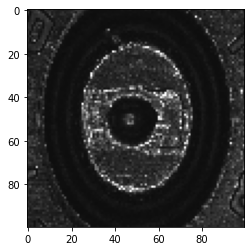

In [35]:
plt.imshow(np.array(train_set[0]))

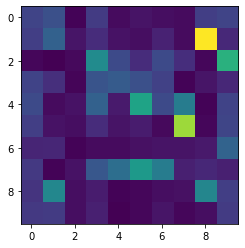

In [21]:
plt.imshow(np.array(val_image[0][0][0]))

# Criaçao de modelo normal

In [59]:
def create_model():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', input_shape=input))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(3, 3))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(3, 3))
    model.add(Flatten())
    model.add(tf.keras.layers.Dense(128, activation="sigmoid"))
    model.add(tf.keras.layers.Dense(64, activation="sigmoid"))
    model.add(tf.keras.layers.Dense(5, activation="softmax"))
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])

    return model


# Criaçao de modelo com transfer learning VGG16 (precisa de input RGB)

In [16]:
def create_model():
    p_model = tf.keras.applications.vgg16.VGG16(input_shape = input, weights = "imagenet", include_top=False)
    p_model.trainable = False
    inputs = p_model.input
    x = Conv2D(32, 3, activation="relu")(inputs)
    x = MaxPool2D((4,4))(x)
    x = Conv2D(32, 3, activation="relu")(x)
    x = Conv2D(32, 3, activation="relu")(x)
    x = Flatten()(p_model.output)
    x = Dense(5, activation="relu")(x)
    model = Model(inputs, x)
    model.summary()
    model.compile(loss = "categorical_crossentropy", optimizer= "Adam", metrics=["accuracy"])
    return model

create_model().summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)      

# Fit para data generator (mais lento)

In [54]:
cnn = create_model()
cnn.fit(train_images, validation_data= val_image,epochs = 10, verbose = 1)

Epoch 1/10
 3/10 [========>.....................] - ETA: 27s - loss: 1.6137 - accuracy: 0.2318

KeyboardInterrupt: 

# Fit para modelo com array (mais rápido)

In [60]:
cnn = create_model()
print(train_set.shape)
cnn.fit(train_set, train_labels, validation_split=0.2, batch_size = 32, epochs = 20, verbose = 1)

(1595, 100, 100, 1)
Epoch 1/20
40/40 [==============================] - 3s 74ms/step - loss: 1.5988 - accuracy: 0.2461 - val_loss: 1.5283 - val_accuracy: 0.3542
Epoch 2/20
40/40 [==============================] - 2s 56ms/step - loss: 1.4905 - accuracy: 0.3409 - val_loss: 1.4296 - val_accuracy: 0.4075
Epoch 3/20
40/40 [==============================] - 2s 56ms/step - loss: 1.3315 - accuracy: 0.4702 - val_loss: 1.2306 - val_accuracy: 0.5423
Epoch 4/20
40/40 [==============================] - 2s 56ms/step - loss: 1.0429 - accuracy: 0.6387 - val_loss: 0.9782 - val_accuracy: 0.6332
Epoch 5/20
40/40 [==============================] - 2s 56ms/step - loss: 0.8252 - accuracy: 0.7100 - val_loss: 0.8365 - val_accuracy: 0.6897
Epoch 6/20
40/40 [==============================] - 2s 56ms/step - loss: 0.6706 - accuracy: 0.7704 - val_loss: 0.6906 - val_accuracy: 0.7461
Epoch 7/20
40/40 [==============================] - 2s 56ms/step - loss: 0.5311 - accuracy: 0.8323 - val_loss: 0.6039 - val_accuracy: 